In [1]:
import numpy as np
import os
import skimage.io as skio
import skimage.transform as skit
from sklearn.pipeline import Pipeline

import pulse2percept as p2p
import p2pmodelselect
import p2pspatial
# console = logging.StreamHandler()
# console.setLevel(logging.ERROR)

%matplotlib inline
import matplotlib.pyplot as plt

2017-11-12 17:48:33,095 [pulse2percept] [INFO] Welcome to pulse2percept


In [10]:
p2p.retina.dva2ret(5)

1347.5261375

In [12]:
rootfolder = 'C:/Users/mbeyeler/data/secondsight/shape/52-001'
subject = None
electrodes = 'A05'
scaling = 8
img_shape = (41, 61)
X, y = p2pspatial.load_data(rootfolder, subject=subject, electrodes=electrodes,
                            scaling=scaling, img_shape=img_shape)

Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Could not parse row: 20100121_112209_trial15 blank
Could not parse row: 20100121_112209_trial43 blank
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Runtime error with minimum threshold
Could not parse row: 20100429_100826_trial3 blank
Could not parse row: 20100429_100826_trial20 blank
Could not parse row: 20100429_100826_trial32 blank
Could not parse row: 20100429_100826_trial33 blank
Found 15 samples: 13 feature values, 7 target values


### Setup

In [3]:
n_jobs = 1
n_folds = 5
sensitivity_rule = 'decay'
cvmethod = 'random'
cvparams = {'n_iter': 2}
search_params = {'reg__decay_const': np.arange(1, 2),
                 'reg__implant_x': np.linspace(-100, 100, 2),
                 'reg__implant_y': np.linspace(-100, 100, 2),
                 'reg__implant_rot': np.linspace(0, 2 * np.pi, 3)}
fit_params = {'reg__sampling': 200,
              'reg__sensitivity_rule': sensitivity_rule}
pipe = Pipeline([('reg', p2pspatial.SpatialModelRegressor())])
validator = p2pmodelselect.ModelValidator(pipe, search_params, fit_params=fit_params,
                                          cvmethod=cvmethod, cvparams=cvparams,
                                          n_jobs=n_jobs)

### Visualize

In [4]:
best_params = {'reg__decay_const': 5,
               'reg__implant_x': 0,
               'reg__implant_y': 0,
               'reg__implant_rot': 0}
pipe.set_params(**best_params)
pipe.fit(X, **fit_params)

Pipeline(memory=None, steps=[('reg', SpatialModelRegressor())])

In [5]:
%%timeit
row = X.iloc[0, :]
mp = pipe.steps[0][1].model_params
implant = p2p.implants.ArgusII(x_center=mp['implant_x'],
                                           y_center=mp['implant_y'],
                                           rot=mp['implant_rot'])
sim = p2pspatial.SpatialSimulation(implant)
sim.set_optic_fiber_layer(sampling=mp['sampling'],
                          x_range=p2p.retina.dva2ret((-30, 30)),
                          y_range=p2p.retina.dva2ret((-20, 20)),
                          decay_const=mp['decay_const'],
                          sensitivity_rule=mp['sensitivity_rule'])
electrode = '%s%d' % (row['electrode'][0], int(row['electrode'][1:]))
img = sim.pulse2percept(electrode)

770 ms ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


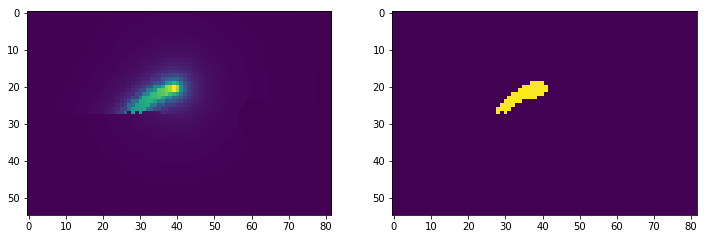

In [6]:
row = X.iloc[0, :]
mp = pipe.steps[0][1].model_params
implant = p2p.implants.ArgusII(x_center=mp['implant_x'],
                                           y_center=mp['implant_y'],
                                           rot=mp['implant_rot'])
sim = p2pspatial.SpatialSimulation(implant)
sim.set_optic_fiber_layer(sampling=mp['sampling'],
                          x_range=p2p.retina.dva2ret((-30, 30)),
                          y_range=p2p.retina.dva2ret((-20, 20)),
                          decay_const=mp['decay_const'],
                          sensitivity_rule=mp['sensitivity_rule'])
# get rid of the leading zeros
electrode = '%s%d' % (row['electrode'][0], int(row['electrode'][1:]))
img = sim.pulse2percept(electrode)
res_shape = (row['img_shape'][0] * row['scaling'],
             row['img_shape'][1] * row['scaling'])
props = p2pspatial.get_region_props(img, res_shape=res_shape, verbose=False)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(p2pspatial.get_thresholded_image(img))

## Run grid search

In [7]:
from sklearn.model_selection import ParameterGrid
from sklearn.base import clone

def gridscore(g, ppipe, XX, yy, model_params={}):
    pipe = clone(ppipe)
    pipe.set_params(**g)
    pipe.fit(XX, **model_params)
    return pipe.score(XX, yy)

grid = ParameterGrid(search_params)
scores = p2p.utils.parfor(gridscore, grid, func_args=[pipe, X, y],
                          func_kwargs={'model_params': fit_params})

### Run grid search with cross-validation

In [8]:
X_test, y_true, y_pred, cv_results = p2pmodelselect.utils.crossval_predict(
    validator, X, y, n_folds=n_folds
)

AssertionError: 